In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingClassifier
from joblib import dump, load
from sklearn.naive_bayes import GaussianNB 
from VisionUtils import *
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd

In [48]:
feat1 = np.load("features/feat1.npy")
feat2 = np.load("features/feat2.npy")
labels = np.load("features/labels.npy")

In [49]:
f1 = [feat1[i1].reshape(-1,1) for i1 in range(len(feat1))]
f2 = [feat2[i2].reshape(-1,1) for i2 in range(len(feat2))]
cos_d = np.array([feat_distance_cosine_scalar(f1[i].T, f2[i]) for i in range(len(feat1))])
cos_d = cos_d.reshape(-1,1)
eucl_d = np.array([ np.linalg.norm(f1[i]- f2[i]) for i in range(len(feat1))]).reshape(-1,1)
sqr_diff = np.power(np.abs(feat1- feat2), 2)

In [50]:
data = np.hstack([cos_d, sqr_diff])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
f_selector = SelectKBest(chi2, k = int(0.8*(len(data.T))))
data_ = f_selector.fit_transform(scaled_data, labels)

In [51]:
data_df = pd.DataFrame(data_)
image_paths_csv = pd.read_csv("features/image_paths.csv", index_col = False)

In [52]:
all_data_df = pd.concat([image_paths_csv,data_df], axis = 1)

In [53]:
len(all_data_df)

8800

In [54]:
xtrain, xtest, ytrain, ytest = train_test_split(all_data_df, labels, shuffle = True, random_state = 42)

In [55]:
paths_dict = {
    "train_paths1": xtrain["path1"],
    "train_paths2": xtrain["path2"],
    "test_paths1": xtest["path1"],
    "test_paths2": xtest["path2"]
}
xtrain1 = xtrain.drop(["path1", "path2", "Unnamed: 0"], axis = 1).values
xtest1 = xtest.drop(["path1", "path2", "Unnamed: 0"], axis = 1).values

Gradient Boosting Classifier

In [56]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

In [57]:
gboost = GradientBoostingClassifier(loss= 'exponential', n_estimators= 200)
gboost.fit(xtrain1, ytrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [58]:
pred = gboost.predict(xtest1)

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score 
acc = accuracy_score(ytest,pred)
conf = confusion_matrix(ytest, pred)
rs = recall_score(ytest, pred)
ps = precision_score(ytest, pred)
f1 = f1_score(ytest, pred)
print("-The Accuracy of the the cllasifier:",acc)
print("-The recall Score: ", rs)
print("-The precision score: ", ps)
print("-The F1_score: ", f1)
print("-The confusion matrix:" )
print(conf)

-The Accuracy of the the cllasifier: 0.8827272727272727
-The recall Score:  0.8604860486048604
-The precision score:  0.902738432483475
-The F1_score:  0.88110599078341
-The confusion matrix:
[[986 103]
 [155 956]]


In [60]:
ytest[1]

0

In [61]:
false_positive = []
false_positive_pred = []

false_negative = []
false_negative_pred = []

for i in range(len(pred)):
    ### False Positive check
    if ((pred[i]==1) & (ytest[i] ==0)):
        false_positive.append(i)
        false_positive_pred.append(pred[i])
    ### False Negative check
    elif ((pred[i] == 0) &(ytest[i]==1)):
        false_negative.append(i)
        false_negative_pred.append(pred[i])


In [62]:
print(len(false_positive))
print(len(false_negative))

103
155


False Positves

In [63]:
false_image_lst1 = list(np.array(paths_dict["test_paths1"])[false_negative])
false_image_lst2 = list(np.array(paths_dict["test_paths2"])[false_negative])

In [64]:
%matplotlib inline

import matplotlib.pyplot as plt 
def showfalse(idx, i):
    print()
    print(i)
    img = plt.imread("data/images/" + false_image_lst1[idx])
    img1 = plt.imread("data/images/" + false_image_lst2[idx])
    print("Prediction value:", false_negative_pred[idx])
    plt.figure(i)
    print("data/images/" + false_image_lst1[idx])
    plt.subplot(212)
    plt.imshow(img)
    print("data/images/" + false_image_lst2[idx])
    plt.subplot(221)
    plt.imshow(img1)
    print()


17
Prediction value: 0
data/images/n007159/0077_01.jpg
data/images/n007159/0478_01.jpg

17

18
Prediction value: 0
data/images/n000740/0146_09.jpg
data/images/n000740/0022_01.jpg

18

19
Prediction value: 0
data/images/n000740/0146_02.jpg
data/images/n000740/0197_01.jpg

19

20
Prediction value: 0
data/images/n000746/0032_01.jpg
data/images/n000746/0370_02.jpg

20

21
Prediction value: 0
data/images/n001197/0351_01.jpg
data/images/n001197/0177_01.jpg

21

22
Prediction value: 0
data/images/n002245/0121_01.jpg
data/images/n002245/0089_01.jpg

22

23
Prediction value: 0
data/images/n001211/0405_02.jpg
data/images/n001211/0025_01.jpg

23

24
Prediction value: 0
data/images/n000106/0059_01.jpg
data/images/n000106/0182_02.jpg

24

25
Prediction value: 0
data/images/n006211/0235_02.jpg
data/images/n006211/0259_01.jpg

25

26
Prediction value: 0
data/images/n000624/0426_01.jpg
data/images/n000624/0085_02.jpg

26

27
Prediction value: 0
data/images/n001299/0171_01.jpg
data/images/n001299/0024

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



39

40
Prediction value: 0
data/images/n000785/0416_01.jpg
data/images/n000785/0527_01.jpg

40

41
Prediction value: 0
data/images/n001299/0195_01.jpg
data/images/n001299/0144_01.jpg

41

42
Prediction value: 0
data/images/n001211/0115_01.jpg
data/images/n001211/0328_02.jpg

42

43
Prediction value: 0
data/images/n001211/0196_01.jpg
data/images/n001211/0314_01.jpg

43

44
Prediction value: 0
data/images/n000775/0133_02.jpg
data/images/n000775/0092_02.jpg

44

45
Prediction value: 0
data/images/n002245/0169_01.jpg
data/images/n002245/0029_02.jpg

45

46
Prediction value: 0
data/images/n000928/0459_03.jpg
data/images/n000928/0141_02.jpg

46

47
Prediction value: 0
data/images/n000040/0235_01.jpg
data/images/n000040/0148_02.jpg

47

48
Prediction value: 0
data/images/n000596/0146_01.jpg
data/images/n000596/0265_01.jpg

48

49
Prediction value: 0
data/images/n000928/0016_02.jpg
data/images/n000928/0221_01.jpg

49


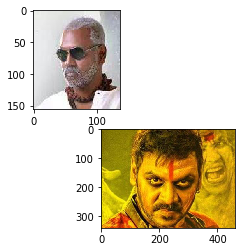

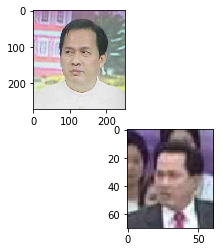

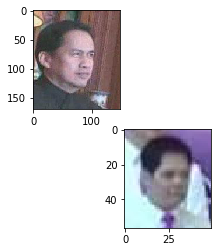

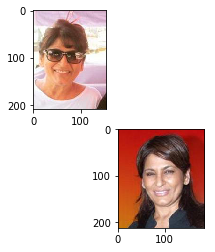

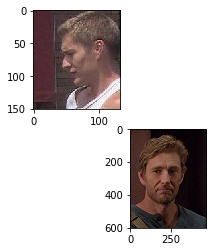

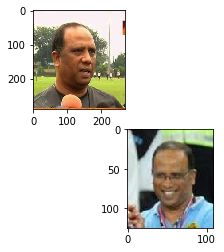

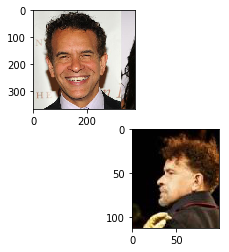

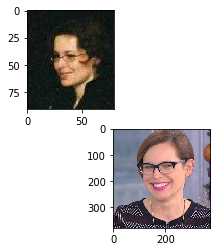

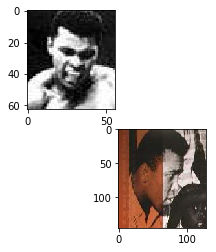

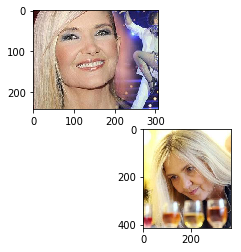

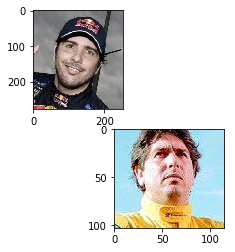

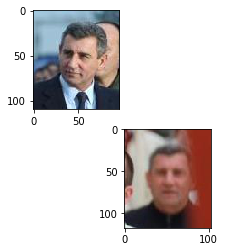

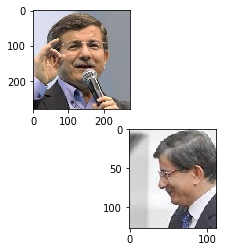

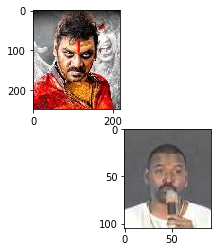

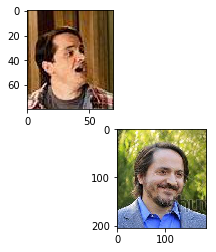

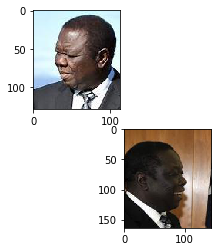

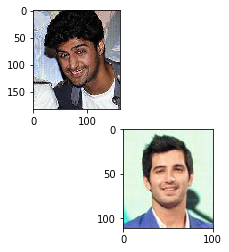

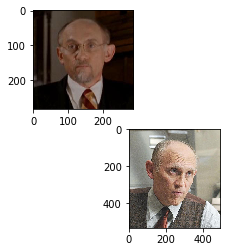

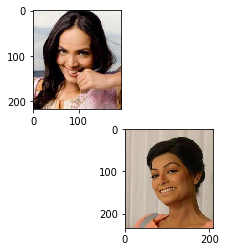

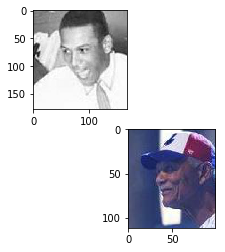

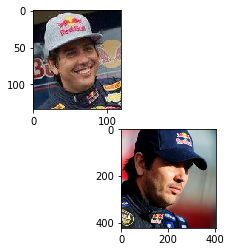

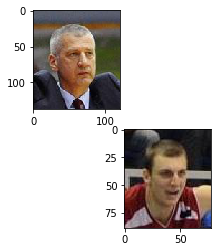

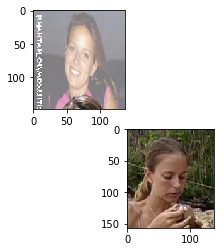

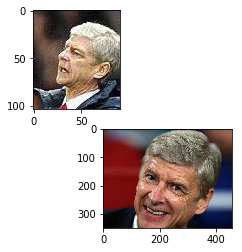

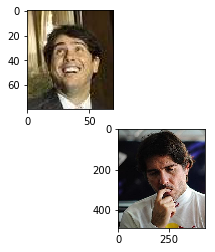

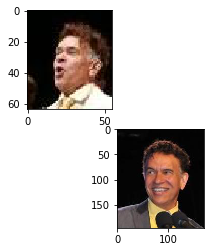

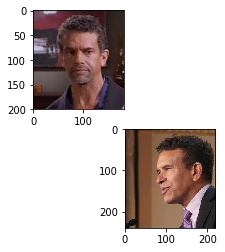

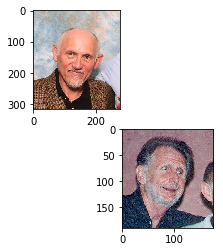

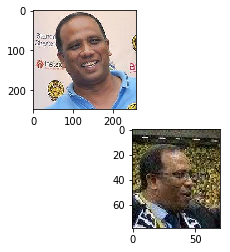

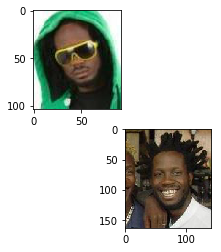

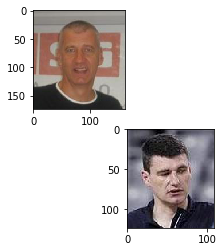

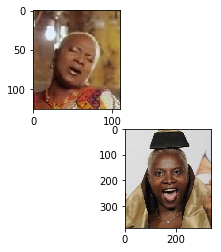

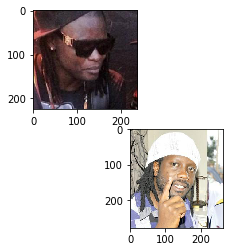

In [66]:
for i in range(17, 50):
    showfalse(i, i)
    print(i)

In [67]:
dump(gboost, "demo/PipelineParts/GboostModel.joblib")
dump(scaler, "demo/PipelineParts/scaler.joblib")
dump(f_selector, "demo/PipelineParts/feature_selector.joblib")

['demo/PipelineParts/feature_selector.joblib']